# Simulation of model

In [35]:
import numpy as np
import pandas as pd
from sympy import symbols, solve, Eq
from scipy.optimize import fmin
import math
import matplotlib.pyplot as plt
import seaborn as sns

## Setup
draw n random values for sigma

define $\pi$, $\phi$ and $\alpha$

count    1000.000000
mean      833.703485
std       453.863092
min       152.602837
25%       529.888678
50%       722.654890
75%      1006.278486
max      3782.317441
dtype: float64


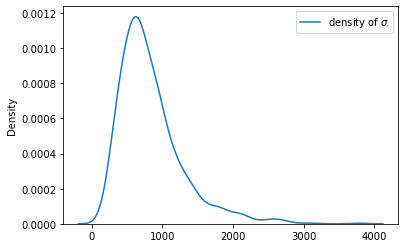

In [36]:
# number of random sigmas
np.random.seed(111)
n = 1000
# mean and sd of normal distribution 
m, s = 2,0.5
sigma = np.random.lognormal(mean=m, sigma=s, size=n) # takes values for normal distribution as inputs
# make to list
sigma = sigma.tolist()
sigma = [x * 100 for x in sigma] # rescaling sigma
print(pd.Series(sigma).describe())
# distribution
sns.kdeplot(sigma, label=r'density of $\sigma$')
plt.legend()


pi = 250
phi = 50
alpha = 0.8


## Fine Schedule

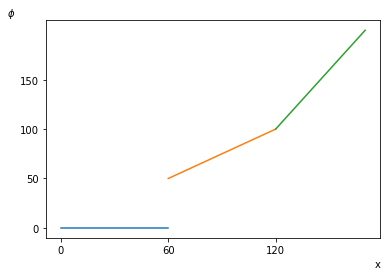

In [37]:
x0, y0 = [0,60], [0,0]
x1, y1 = [60, 120], [50,100]
x2, y2 = [120,170], [100,200]
plt.plot(x0, y0)
plt.plot(x1,y1,x2, y2)
plt.xticks([0,60,120])
plt.yticks([0,50,100,150])
plt.xlabel('x', loc = 'right')
plt.ylabel(r'$\phi$', loc = 'top', rotation = 'horizontal')
plt.show()

## Cost functions
fixing cost function $C(x,\sigma) = \frac{\sigma}{\alpha} (\frac{x}{\sigma})^{-\alpha}$

Text(0, 0.5, 'C(x)')

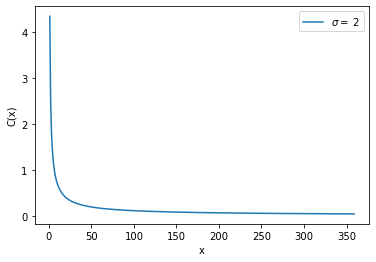

In [38]:
def C(x, sigma, alpha):
    first = sigma / alpha
    second = x / sigma
    power = -alpha
    return  first * (second**power)


# plot for fixed sigma
sigma_fix = 2
x = np.arange(1,360,1)  
plt.plot(x,C(x,sigma_fix, alpha), label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('C(x)')

Cost function $K(x,\sigma) = (\pi + \phi)x + C(x, \sigma)$ with x, $\sigma$, $\pi$ and $\phi$ as inputs, $\phi = 50$ Rs if $x > 60$

Text(0, 0.5, 'K(x)')

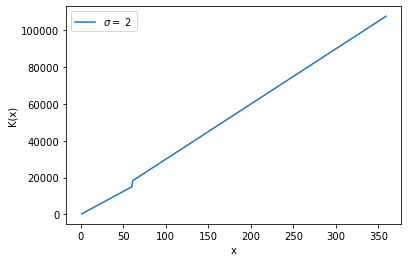

In [39]:
def K(x,sigma, pi, phi, alpha):
    if x <= 60:
        exp =  (pi) * x + C(x, sigma, alpha)
    elif x > 60:  
        exp = (pi + phi) * x + C(x, sigma, alpha)  
    return exp


# plot K with fixed sigma 
x = np.arange(1,360,1)
Ks = [K(x,sigma = sigma_fix, pi = pi, phi = phi, alpha = alpha) for x in x]  
plt.plot(x,Ks, label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('K(x)')  

optimal x as a function of $\sigma$ : $x = \sigma (\pi + \phi)^{-1/(1+\alpha)}$

xopts: count    1000.000000
mean       38.799196
std        21.122045
min         7.101886
25%        24.660152
50%        33.631176
75%        46.830554
max       176.022863
dtype: float64
xopts2: count    1000.000000
mean       35.061714
std        19.087383
min         6.417770
25%        22.284668
50%        30.391523
75%        42.319421
max       159.066784
dtype: float64


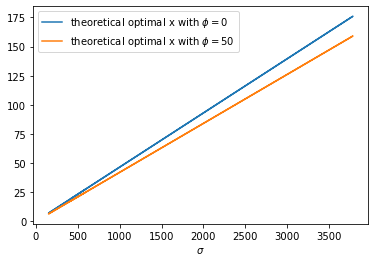

In [40]:
# optimal theoretical x without phi
def xopt(sigma, pi=pi, phi=phi, alpha = alpha):
    x = sigma * (pi + phi)**(-1/(1+alpha))
    return x

xopts = [xopt(s, phi=0) for s in sigma]

# optimal theoretical x with phi
xopts2 = [xopt(s, phi=phi) for s in sigma]

print('xopts:',pd.Series(xopts).describe())
print('xopts2:',pd.Series(xopts2).describe())

plt.plot(sigma, xopts, label =r'theoretical optimal x with $\phi = 0$')
plt.plot(sigma, xopts2, label =f'theoretical optimal x with $\phi = {phi}$')

plt.xlabel(r'$\sigma$')
plt.legend()


### Fine schedule tradeoff
$\pi*60 + \frac{\sigma}{\alpha} \pi^{\alpha/(1+\alpha)} \geq (\pi + \phi)^{\alpha/(1+\alpha)} (\sigma + \frac{\sigma}{\alpha})$

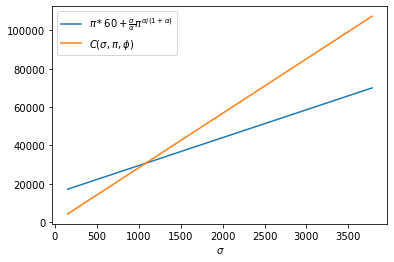

In [41]:
left = [60*pi + s/alpha * pi**(alpha/(1+alpha))  for s in sigma]
right = [(pi + phi)**(alpha/(1+alpha)) * (s + s/alpha) for s in sigma]
tradeoff = pd.DataFrame({'sigma':sigma, 'left':left, 'right':right}).sort_values('sigma')

plt.plot(tradeoff.sigma, tradeoff.left, label = r'$\pi*60 + \frac{\sigma}{\alpha} \pi^{\alpha/(1+\alpha)}$')
plt.plot(tradeoff.sigma, tradeoff.right, label = r'$C(\sigma, \pi, \phi)$')
plt.xlabel(r'$\sigma$')
plt.legend()

solve for $\sigma$ where equality holds

In [42]:
s = symbols('s')
exp = 60*pi + s/alpha * pi**(alpha/(1+alpha)) - (pi + phi)**(alpha/(1+alpha)) * (s + s/alpha)
sigma_bar = solve(exp)
if len(sigma_bar) > 0:
    print('optimal sigma is', f'{sigma_bar[0]:.2f}')
else: print('lines do not intersect')

sigma_bar = sigma_bar[0]

optimal sigma is 1083.49


# therotical x combining both.. Let's call this D
# here we should use the equation solving for sigma bar (at the very bottom) which will give us a sigma below which we take xopt and above which we take xopts2. create a variable s.t. x = xopts if sigma<sigma bar and x = xopts2 otherwise. 

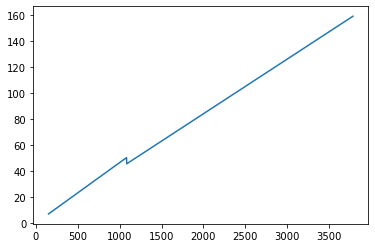

In [43]:
combined = [xopt(s, phi=0) if s <= sigma_bar else xopt(s, phi=phi) for s in sigma]
combined_sorted = [xopt(s, phi=0) if s <= sigma_bar else xopt(s, phi=phi) for s in sorted(sigma)]

plt.plot(sorted(sigma), combined_sorted)


This is not entirely correct because it doesnt include bunching. To include bunching: recall that a firm will bunch (meaning choose x = 60) if the cost of not bunching at xopts2 (paying phi) is higher than the cost of bunching (choosing x=60 and not paying phi). This will be a range between sigma at xopts=60.
Step 1: solve for sigma from xopts = 60 (phi = 0)

Step 2: solve for sigma indifference as above

Step 3: replace x = 60 for all sigma between the two sigmas

Step 4: replace x = xopts for the sigmas below sigma in step 1, and x = xopts2 for the sigmas above sigma indifference in step 2. 

Let's do this and plot D against the x's we're getting from the minimizations.

1283.4969664291118 1083.49087642364


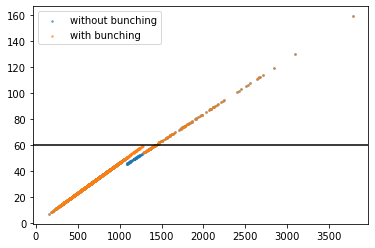

In [53]:
dfx = pd.DataFrame(list(zip(sigma, xopts, xopts2, combined)), columns=['sigma', 'xopts', 'xopts2', 'combined'])

# find sigma for x close to 60 but below??
step1 = dfx.loc[dfx['xopts'][dfx.xopts <= 60].sub(60).abs().idxmin(),'sigma']
#print(df.loc[df['xopts'].sub(60).abs().idxmin(),])

# step 2: sigma_bar
print(step1, sigma_bar)

# step 3
dfx['combined'] = dfx.apply(lambda row: 60 if (row.sigma > sigma_bar and row.sigma < step1) else row.combined, axis = 1)

# step 4
dfx['combined'] = dfx.apply(lambda row: row.xopts if row.sigma < step1 else (row.xopts2 if row.sigma > sigma_bar else row.combined), axis = 1)


plt.scatter(sigma, combined,marker = 'o', label='without bunching', alpha=.5, s = 3)
plt.scatter(dfx.sigma, dfx.combined,marker = 'o', label='with bunching', alpha=.5, s= 3)
plt.axhline(60, color ='black')
plt.legend()


### Minimization
find the minimum x of K() for all sigmas

In [45]:
xstar = {}
for s in sigma:
    #if s < 150:
    x_start = xopt(s, pi=pi, phi=phi, alpha=alpha)
    x = fmin(K,x0 = x_start, args=(s,pi, phi, alpha), disp=True) 
    #else: x[0] = np.nan    
    if x < 0:
        raise ValueError('x negative')
    xstar[s] = x[0] # output of fmin is a list, access first element

### DANA
'''
xstar = {}
for s in sigma:
    #if s < 150:
    x_start = xopt(s, pi=pi, phi=phi, alpha=alpha)
    x = fmin(K, x0 = x_start, args=(s,pi,phi,alpha))
    #x = minimize(K, x0 = x_start, args=(s,pi, phi, alpha), method = 'Nelder-Mead', 
     #            options={'disp': False}) 
    #else: x[0] = np.nan    
    #if x < 0:
     #   raise ValueError('x negative')
    xstar[s] = x[0] # output of minimize is an array?? 
'''
   

Optimization terminated successfully.
         Current function value: 10972.680429
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 23441.016975
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 44328.882713
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 16193.932010
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 13047.036018
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 15372.931984
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 18779.077809
         Iterations: 16
         Function evaluations: 32
Optimi

"\nxstar = {}\nfor s in sigma:\n    #if s < 150:\n    x_start = xopt(s, pi=pi, phi=phi, alpha=alpha)\n    x = fmin(K, x0 = x_start, args=(s,pi,phi,alpha))\n    #x = minimize(K, x0 = x_start, args=(s,pi, phi, alpha), method = 'Nelder-Mead', \n     #            options={'disp': False}) \n    #else: x[0] = np.nan    \n    #if x < 0:\n     #   raise ValueError('x negative')\n    xstar[s] = x[0] # output of minimize is an array?? \n"

now put all all in a dataframe and calculate the costs for the optimal x's

In [46]:
df = pd.DataFrame.from_dict(xstar, orient='index', columns=['xstar'])
df = df.reset_index()
df = df.rename(columns={'index':'sigma'})


# calculate fixing cost C
df['fixing_cost'] = df.apply(lambda row: C(row.sigma,row.xstar, alpha=alpha), axis=1)
# calculate cost K
df['K'] = df.apply(lambda row: K(row.xstar, row.sigma, pi = pi, phi = phi, alpha=alpha), axis=1)

print(df.xstar.describe())
df.head()

count    1000.000000
mean       37.864379
std        18.978852
min         7.101851
25%        24.660167
50%        33.631196
75%        46.830582
max       159.066784
Name: xstar, dtype: float64


,sigma,xstar,fixing_cost,K
0,419.159292,19.506999,2.095799,10972.680429
1,895.453042,41.672944,4.477270,23441.016975
2,1561.570109,65.672419,6.506542,44328.882713
3,618.612482,28.789230,3.093066,16193.932010
4,498.400223,23.194745,2.492004,13047.036018


## Plots
compare the theoretical x and the x calculated from minimization and their density

should we use here the theoretical one with bunching?

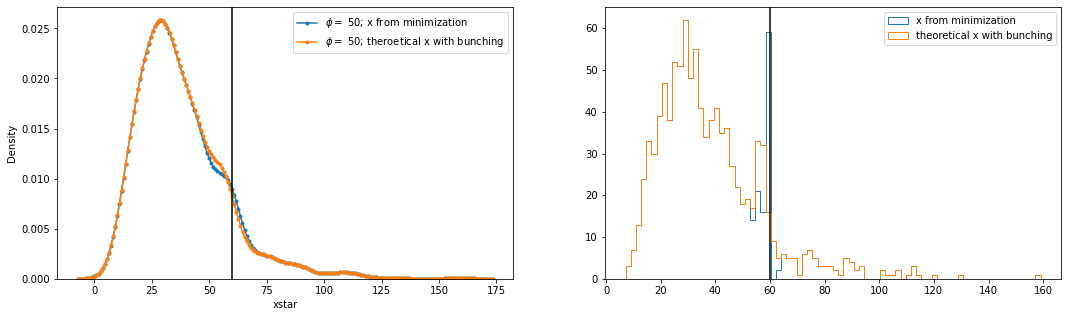

In [47]:
fig, axs = plt.subplots(1,2,figsize=(18,5))
sns.kdeplot(df.xstar, marker='o', markersize=3, label = f'$\phi =$ {phi}; x from minimization', ax=axs[0]) 
sns.kdeplot(dfx.combined, marker='o', markersize=3, label = f'$\phi =$ {phi}; theroetical x with bunching', ax=axs[0]) 
axs[0].axvline(60, color = 'black')
axs[0].legend()
## Can we also plot the histograms of the xstar and xopt like the graph I showed you with the real data? e.g. number of observations in each bin (3 min)
n_bins = round(df.xstar.max()/2)
axs[1].hist(df.xstar, histtype='step', bins = n_bins, label='x from minimization')
axs[1].hist(dfx.combined, histtype='step', bins =n_bins, label='theoretical x with bunching')
axs[1].axvline(60, color = 'black')
axs[1].legend()
plt.show()

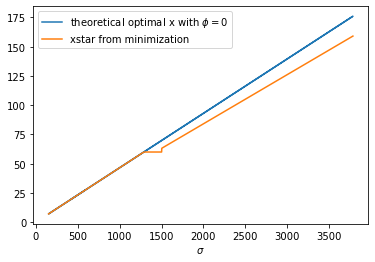

In [48]:
df_order = df.sort_values('sigma')

plt.plot(sigma, xopts, label=r'theoretical optimal x with $\phi = 0$')
plt.plot(df_order.sigma, df_order.xstar, label='xstar from minimization' )
#plt.xlim(0,200)
plt.xlabel(r'$\sigma$')
plt.legend()

plot the optimal $x(\sigma)$ and the functions $C(x,\sigma)$ and $K(x,\sigma)$

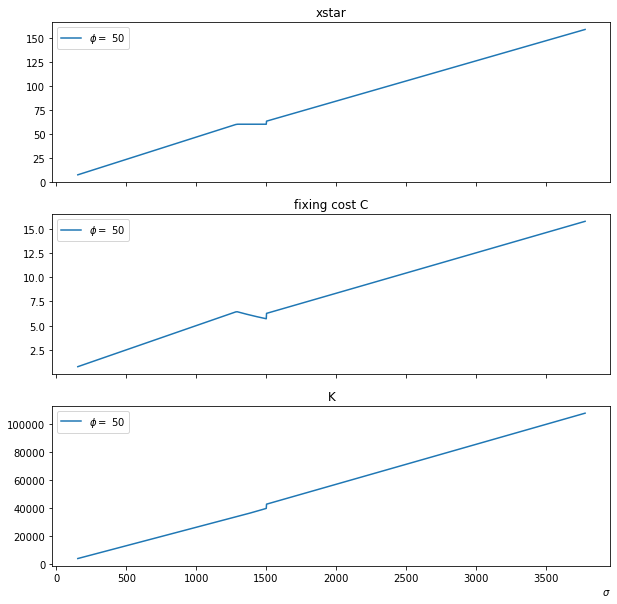

In [49]:
# first sort df in ascending order for sigmas
df_order = df.sort_values('sigma')

fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
axs[0].plot(df_order.sigma, df_order.xstar, label=f'$\phi =$ {phi}')
axs[0].set_title('xstar')
axs[1].plot(df_order.sigma, df_order.fixing_cost, label=f'$\phi =$ {phi}')
axs[1].set_title('fixing cost C')
axs[2].plot(df_order.sigma, df_order.K, label=f'$\phi =$ {phi}')
axs[2].set_title('K')
axs[2].set_xlabel(r'$\sigma$', loc='right')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

## Indifference condition - Visualization  

{c: 799.698648092585}


<ipython-input-38-0ded1f1956e1>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return  first * (second**power)
<ipython-input-38-0ded1f1956e1>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return  first * (second**power)


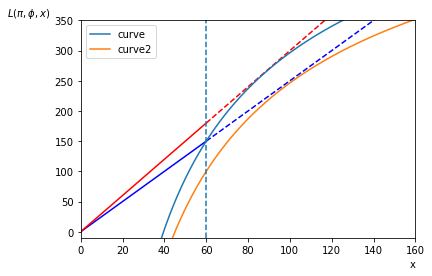

In [50]:
def curve(x, s,a, c=65):
    y = c-C(x,sigma=s, alpha=a)
    return y

# must go through point (60,50)    
s = 185
a = .5

# I rescale it here because it would be very steep otherwise
slope1 = pi /100
slope2 = (pi + phi) /100

c=symbols('c')
exp = Eq(60*slope1 - curve(60, s=s, a=a,c=c),0)
res = solve([exp],(c))
print(res)

# lines
plt.plot([0,60],[0,60 * slope1], color = 'blue')
plt.plot([60,160],[60*slope1, 160*slope1], linestyle='dashed',color = 'blue')
plt.plot([0,60],[0,60 * slope2], color = 'red')
plt.plot([60,160],[60*slope2, 160*slope2], linestyle='dashed',color = 'red')
#curve
x = np.linspace(0,160,160)
y = [curve(x,s=s, a=a, c=res[c]) for x in x]
plt.plot(x,y, label='curve')
y2 = [curve(x,s=s, a=a, c=res[c]-50) for x in x]
plt.plot(x,y2, label='curve2')
plt.axvline(60, linestyle='dashed')
#plt.axvline(res[x], linestyle='dashed')
plt.xlim(0,160)
plt.ylim(-10,350)
plt.xlabel('x', loc='right')
plt.ylabel(r'$L(\pi, \phi, x)$', loc='top', rotation='horizontal')
plt.legend()
plt.show()